# Notebook 04 — Evaluate & Release

**Goal:** Make simple evaluation visuals for the trained model and save them for the README / dashboard.

**What I do here:**
1) Load the saved model + features + ready data  
2) Compute probabilities and basic metrics  
3) Plot & save **ROC Curve**  
4) Plot & save **Confusion Matrix** (threshold = 0.50)  
5) (Nice extra) Try a few thresholds and save a small table

**Inputs:**  
- `../artifacts/v1/rf_pipeline.joblib`  
- `../artifacts/v1/features.json`  
- `../data/processed/hr_attrition_ready.parquet`

**Outputs:**  
- `../assets/roc_curve.png`  
- `../assets/confusion_matrix_050.png`  
- `../assets/threshold_metrics.csv` (extra)

In [5]:
from pathlib import Path
import json, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Paths (notebook is in jupyter_notebooks/, so use ../ to reach project root)
ART = Path("../artifacts/v1")
DATA = Path("../data/processed/hr_attrition_ready.parquet")
ASSETS = Path("../assets")
ASSETS.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ART.resolve())
print("Data file:    ", DATA.resolve())
print("Assets dir:   ", ASSETS.resolve())

Artifacts dir: /workspace/AttriSight/artifacts/v1
Data file:     /workspace/AttriSight/data/processed/hr_attrition_ready.parquet
Assets dir:    /workspace/AttriSight/assets


In [6]:
# Load artifacts
pipe = joblib.load(ART / "rf_pipeline.joblib")
features = json.loads((ART / "features.json").read_text())

# Load data
df = pd.read_parquet(DATA)
X = df[features]
y_true = df["target"].to_numpy()

# Predict probabilities and default 0.50 labels
y_prob = pipe.predict_proba(X)[:, 1]
y_pred = (y_prob >= 0.50).astype(int)

print("Data shape:", df.shape)
print("Features used:", len(features))
print("Sample probs:", np.round(y_prob[:5], 4))
print("Positives @0.50:", int(y_pred.sum()))

Data shape: (1470, 36)
Features used: 15
Sample probs: [0.5564 0.1012 0.5461 0.3452 0.2515]
Positives @0.50: 154


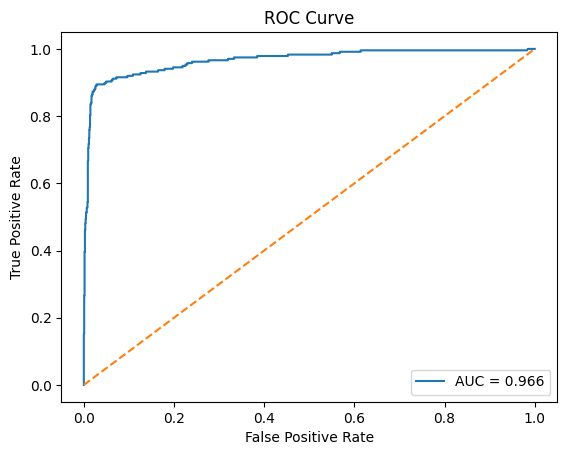

Saved: ../assets/roc_curve.png


In [7]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

out_path = ASSETS / "roc_curve.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", out_path)